In [385]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [386]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+5))+10
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 100*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [387]:
X = []
Y = []
D = 0.01 #almost no diffusion
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

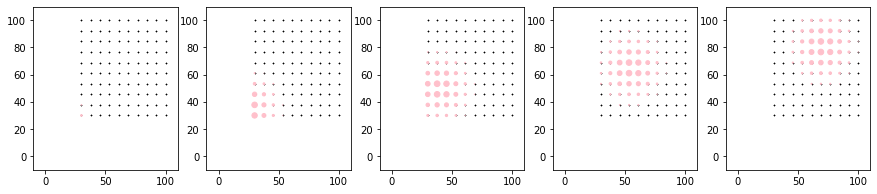

In [388]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [389]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [390]:
boundary

([-7.0, -10, -10], [77.0, 107.0, 107.0])

In [391]:
len(X)

500

In [392]:
np.set_printoptions(precision=1,suppress=True)

(-15.850000000000001, 112.85, -15.850000000000001, 112.85)

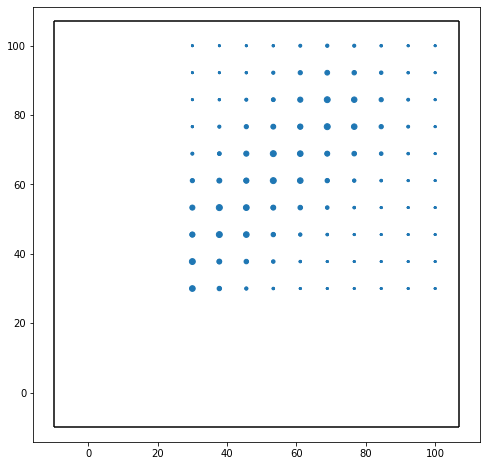

In [393]:
plt.figure(figsize=[8,8])
plt.scatter(X[:,2],X[:,3],3+Y*10)
plt.hlines([boundary[0][2],boundary[1][2]],boundary[0][1],boundary[1][1])
plt.vlines([boundary[0][1],boundary[1][1]],boundary[0][2],boundary[1][2])
#plt.plot([0],[0],'or')
plt.axis('equal')

In [394]:
#set up our model...
N_feat = 2000 #Number of features used to infer the source
k = EQ(20, 1)
res = [50,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
#assert gbs<6, "TOO BIG :("
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference


Memory usage in grid model: 0.48 Gb


In [395]:
#dt: time grid size
#dx: x direction grid size
#dy: y direction grid size
#dx2 = dx**2
#dy2 = dy**2
#Nt: Number of evaluation points in time
#Nx: Number of evaluation points in x axis
#Ny: Number of evaluation points in y axis
mInfer.getGridStepSize()

(1.68, 2.34, 2.34, 5.475599999999999, 5.475599999999999, 50, 50, 50)

In [396]:
mInfer.computeModelRegressors(Nparticles=30) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


In [397]:
tgrid = []
ts = np.unique(X[:,1])
for t in np.unique(X[:,1]):
    tgrid.append(mInfer.getGridCoord([t,0,0])[0])
tgrid

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,5):
    print(".",end="")
    s = mInfer.computeSourceFromPhi(z_samp)
    source_samples.append(s)
    #conc_samples.append(mInfer.computeConcentration(s))
    
source_samples=np.array(source_samples)
#conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

#conc_lower_ci = np.percentile(conc_samples,2.5,0)
#conc_upper_ci = np.percentile(conc_samples,97.5,0)
#conc_mean = np.percentile(conc_samples,50,0)


.....

(-0.5, 49.5, 49.5, -0.5)

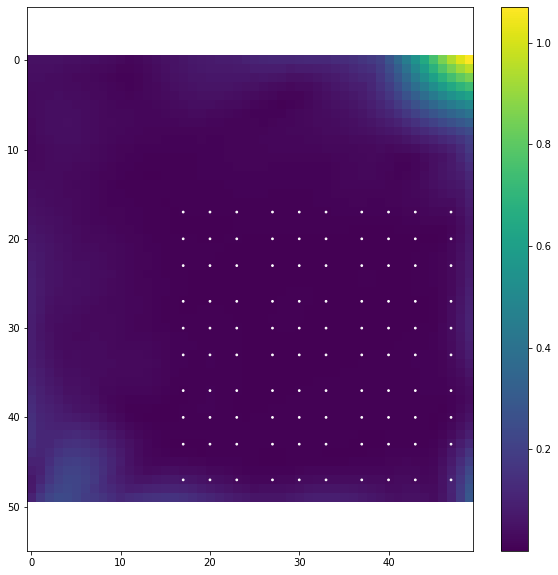

In [398]:
tstep = 0
Xgrid = mInfer.getGridCoord(X[:,[0,2,3]])
t = ts[tstep]
plt.figure(figsize=[10,10])
plt.imshow((source_upper_ci-source_lower_ci)[tgrid[tstep],:,:])
plt.colorbar()
#plt.plot(realsource[2],realsource[1],'xw')
plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]/10,color='w')
plt.axis('equal')

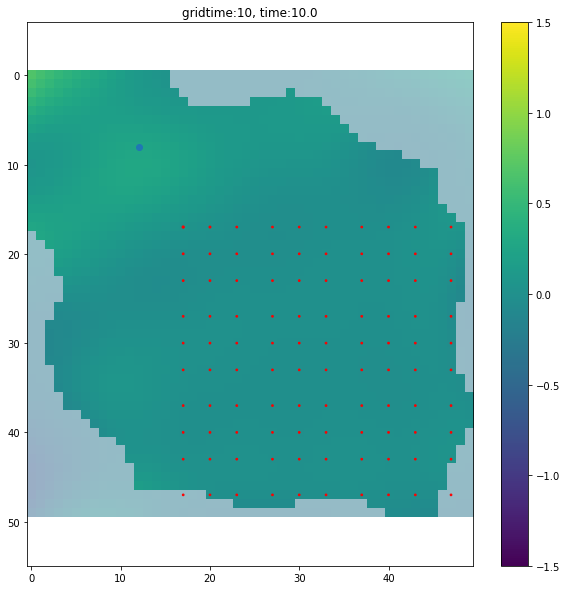

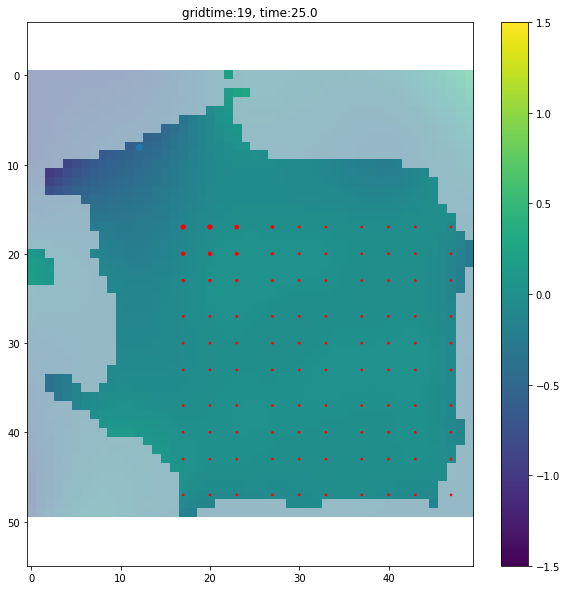

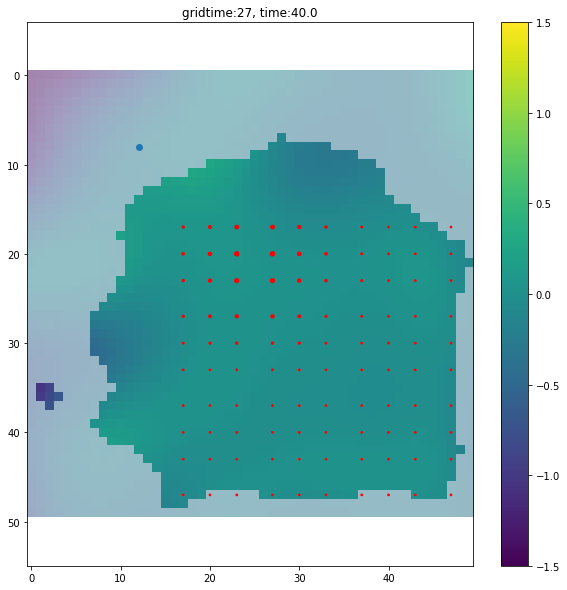

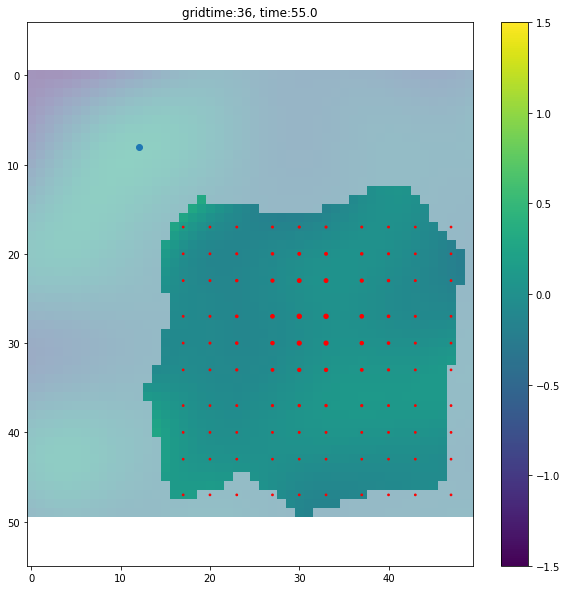

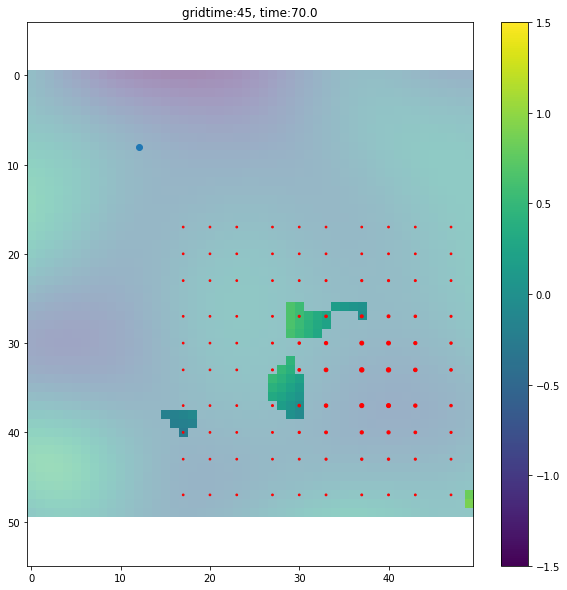

In [399]:
confthreshold = 0.05
for timepoint in range(5):
    tp = tgrid[timepoint]
    t = ts[timepoint]

    conf = (source_upper_ci-source_lower_ci)[tgrid[timepoint],:,:]
    source = sourceInfer[tp,:,:].copy()
    source[conf>confthreshold]=np.NaN

    plt.figure(figsize=[10,10])
    plt.title('gridtime:%d, time:%0.1f' % (tp,ts[timepoint]))
    plt.imshow(sourceInfer[tp,:,:],clim=[-4,6],alpha=0.5)
    plt.imshow(source)#,clim=[-2,2])
    plt.clim([-1.5,1.5])
    plt.colorbar()
    #plt.plot(realsource[2],realsource[1],'xw')
    plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    plt.axis('equal')
    plt.plot(12,8,'o')

In [400]:
#mInfer.computeModelRegressors(Nparticles=30) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution

In [401]:
mInfer.coords.shape

(3, 50, 50, 50)

In [402]:
##mInfer.coords = mInfer.coords[:,::5,::5,::5]
mInfer.coords = mInfer.coords[:,::5,::2,::2] #reduce res a bit

In [403]:
particles = mInfer.coords.transpose([1,2,3,0]).copy()
particles = particles[None,:].repeat(10,axis=0)

In [404]:
particles.shape

(10, 10, 25, 25, 3)

In [405]:
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = mInfer.getGridStepSize() #only bit we use is dt and Nt

#Nparticles = len(particles) #per grid point...
#scale = Nparticles / dt

#particles = []
#N_obs = len(self.sensormodel.obsLocs)

#Place particles at the places of interest...
print("Initialising particles...")
particles = mInfer.coords.transpose([1,2,3,0]).copy()
particles = particles[None,:].repeat(20,axis=0)
conc = np.zeros(particles.shape[:4])
print("Diffusing particles...")
for nit in range(Nt):
    print("%d/%d \r" % (nit,Nt),end="")
    wind = mInfer.windmodel.getwind(particles[:,:,:,:,1:])*dt #how much each particle moves due to wind [backwards]
    particles[:,:,:,:,1:]+=np.random.randn(particles.shape[0],particles.shape[1],particles.shape[2],particles.shape[3],2)*np.sqrt(2*dt*mInfer.k_0) - wind
    particles[:,:,:,:,0]-=dt

    keep = particles[:,:,:,:,0]>mInfer.boundary[0][0] #could extend to be within grid space
    
    #should we be sampling from Z or use the mean?
    sources = mInfer.computeSourceFromPhi(meanZ, particles.transpose([4,0,1,2,3]))
    
    conc[keep] += sources[keep] #np.sum(sources)#[:,keep]
    if np.sum(keep)==0: 
        break
    
conc = np.array(conc) #/scale
conc = np.mean(conc,axis=0)*dt
#self.X = X
#return X

Initialising particles...
Diffusing particles...


In [406]:
gridps = mInfer.coords.transpose([1,2,3,0]).copy()
realconc = np.zeros(mInfer.coords.shape[1:])
for i in np.ndindex(gridps.shape[:3]):
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

<ipython-input-386-d48212c9c158>:3: RuntimeWarning: invalid value encountered in sqrt
  blobsize = np.sqrt(2*2*D*(t+5))+10


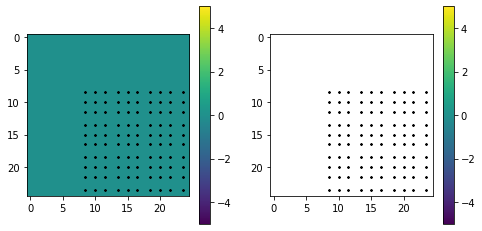

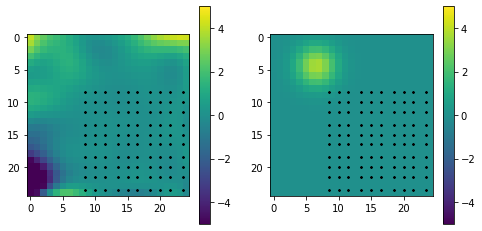

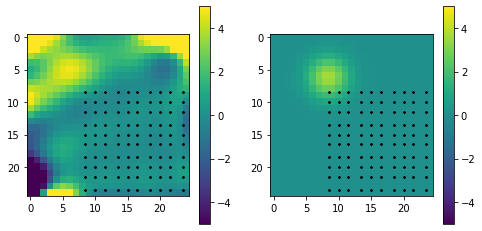

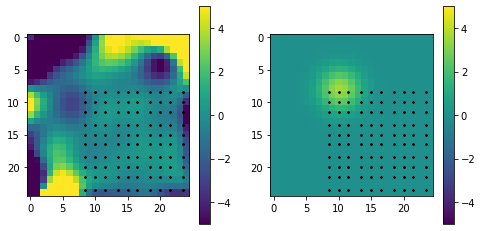

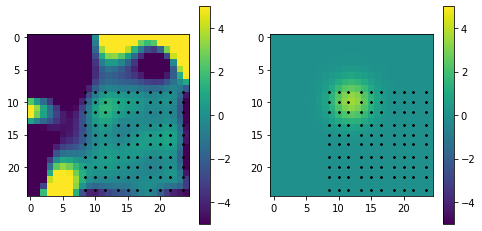

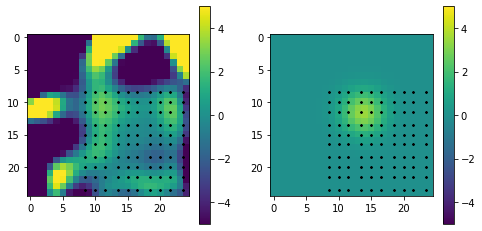

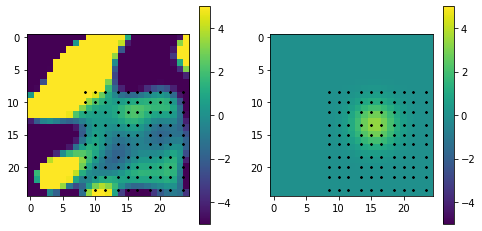

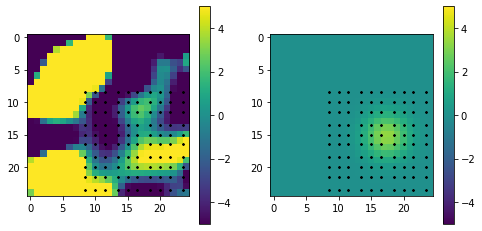

In [407]:
 gridX = mInfer.getGridCoord(X[:,1:])/np.array([5,2,2])

for tsamp in range(8):
    plt.figure(figsize=[8,4])
    plt.title(tsamp)
    plt.subplot(1,2,1)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(conc[tsamp,:,:])
    plt.clim([-5,5])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp,:,:])    
    plt.clim([-5,5])
    plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #

# Other stuff

In [32]:
%timeit -r 5 -n 5 mInfer.computeConcentration(sourceInfer)

19 ms ± 1.28 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [30]:
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

In [22]:
concInfer

array([[[ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00],
        [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00],
        [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00],
        ...,
        [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00],
        [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00],
        [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
          0.0e+00]],

       [[-2.1e-01, -2.4e-01, -2.5e-01, ..., -9.4e-02,  9.2e-02,
          1.9e-01],
        [-3.4e-01, -3.5e-01, -3.3e-01, ...,  4.3e-03,  1.8e-01,
          2.8e-01],
        [-3.6e-01, -3.4e-01, -2.9e-01, ...,  1.4e-01,  2.9e-01,
          3.7e-01],
        ...,
        [ 5.2e-01,  4.8e-01,  4.4e-01, ..., -7.9e-01, -7.4e-01,
         -6.4e-01],
        [ 4.2e-01,  4.3e-01,  4.5e-01, ..., -7.5e-01, -7.3e-01,
         -6.2e-01],
        [ 2.8e-01,  3.5e-01,  4.1e-01, ..., -6.6

In [126]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
%matplotlib inline
samples = np.random.randn(10000,2) #these are effectively constants...N(0,I)
np.set_printoptions(precision=2,suppress=True)


In [155]:
test = np.random.multivariate_normal([0,0],[[1,0.4],[0.4,1]],1)

In [156]:

temp = []
for a in np.linspace(0,0.99,1000):
    covofq = [[1,a],[a,1]]
    meanofq = np.array([0.5,0.5])
    def compute_F(ytest,covofq):
        oursamples = samples@sqrtm(covofq)+meanofq   #samples from p(q)
        return np.sum((ytest-oursamples)**2)/len(oursamples)     #approximates   int p(y|q) p(q) dq
        #dF/da
    temp.append([a,compute_F(np.array([1,2]),covofq)])
    (compute_F(test,covofq+np.array([[0,0.001],[0.001,0]]))-compute_F(np.array([1,2]),covofq))/0.001
    

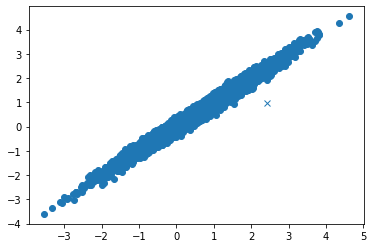

In [157]:
oursamples = samples@sqrtm(covofq)+meanofq 
plt.scatter(oursamples[:,0],oursamples[:,1])
plt.plot(test[:,0],test[:,1],'x')

In [136]:
temp=np.array(temp)

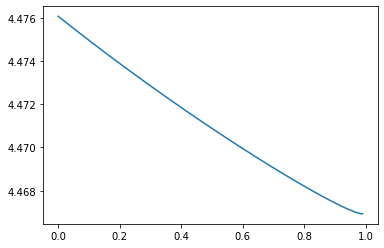

In [137]:
plt.plot(temp[:,0],temp[:,1])

In [91]:
covofq
compute_F(np.array([1,1.1]),covofq)

0.20922703033206907

In [64]:
sqrtm(covofq)

array([[0.85, 0.53],
       [0.53, 0.85]])

In [86]:
v,d,vT = np.linalg.svd(covofq)
v@np.diag(np.sqrt(d))@vT

array([[0.85, 0.53],
       [0.53, 0.85]])